# Auction exercise

We participate in auctions for items characterized by x. In these auctions  each potential buyer must place a single bid, unaware of competitors' bids. The item is awarded to the highest bidder at the price offered. In other words, if we place a bid z and win the auction our costs are equal to z.

The outcomes from the auctions participated are provided in an aggregated format per item. The attached file provides the raw data for a set of auctions participated.

Objectives:
1. Develop a model to predict the probability of winning an auction based on our bid and the item feature x. If you can think of a way, the model should ideally also be able to predict the confidence of predictions.
2. Derive the probability density function for the winning bid for x=3. What is the probability that the winning bid lies between 1 and 2?
3. Let’s assume that we participate again on an identical set of auctions with the same bids as in the provided dataset. Based on your model, what is the probability of observing costs larger than in the provided dataset?

## Imports

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn.metrics as sk_m

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from scipy.stats import gaussian_kde, uniform

In [2]:
random_state = 7

In [3]:
def plot_scores(y_true, y_pred, n_classe:int=2, classe_name=None, modelname='') :
    """
    Arguments :
    Plot the confusion Matrix and different scores
    y_true (array) : Ground truth (correct) target values.
    y_pred (array) :Estimated targets as returned by a classifier.
    """
    N_test = len(y_pred)
    cm = sk_m.confusion_matrix(y_true, y_pred)
    cm_bis = cm.flatten()
    
    if n_classe == 2 :
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = [f"{v : 0.0f}" for v in cm_bis]
        group_percentages = ['{0:.2%}'.format(value) for value in cm_bis/N_test]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
    else :
        group_counts = [f"{v : 0.0f}" for v in cm_bis]
        group_percentages = ['{0:.2%}'.format(value) for value in cm_bis/N_test]
        for i in range(n_classe**2) :
            if int(group_counts[i]) == 0 :
                group_counts[i], group_percentages[i]= '', ''
        labels = [f'{v1}\n{v2}\n' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(n_classe, n_classe)
    
    if classe_name is None :
        classe_name = list(range(n_classe))
        
    plt.figure(figsize=(9, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=classe_name, yticklabels=classe_name)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    print(f"Classification report of the model for this testing set")
    print(sk_m.classification_report(y_true, y_pred, digits=3))
    acc_score = sk_m.accuracy_score(y_true, y_pred)
    print('-'*55 + '\n')

## Data preparation

In [4]:
df_data = pd.read_csv("auctions_summary.csv", delimiter=',')
df_data["losses"] = df_data["auctions"] - df_data["wins"]
df_data["wins_ratio"] = df_data["wins"] / df_data["auctions"]
df_data.describe()

,x,bid,auctions,wins,losses,wins_ratio
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2.866859,1.581527,5.093069,2.190099,2.902970,0.417230
std,1.747467,1.554054,2.224782,2.727633,2.808097,0.454676
min,0.028227,-1.680578,1.000000,0.000000,-3.000000,0.000000
25%,1.256365,0.384293,3.000000,0.000000,0.000000,0.000000
50%,2.862625,0.944562,5.000000,1.000000,3.000000,0.166667
75%,4.394171,2.421456,6.000000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.500000


We assume that the bid is positive, and that we can't win 

In [5]:
df_data = df_data[(df_data["wins_ratio"] <= 1) & (df_data["bid"] >= 0)]

In [6]:
df_data.describe()

,x,bid,auctions,wins,losses,wins_ratio
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.856842,1.598030,5.098000,2.166000,2.932000,0.411617
std,1.747752,1.546013,2.228526,2.709451,2.796967,0.449939
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000
25%,1.242002,0.392008,3.000000,0.000000,0.000000,0.000000
50%,2.860087,0.958994,5.000000,1.000000,3.000000,0.166667
75%,4.391381,2.433355,6.250000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000


## Data visualization

In [7]:
print(f"Ratio of number of auctions win: {df_data['wins'].sum()/df_data['auctions'].sum():.2%}")

Ratio of number of auctions win: 42.49%


<Axes: xlabel='x', ylabel='bid'>

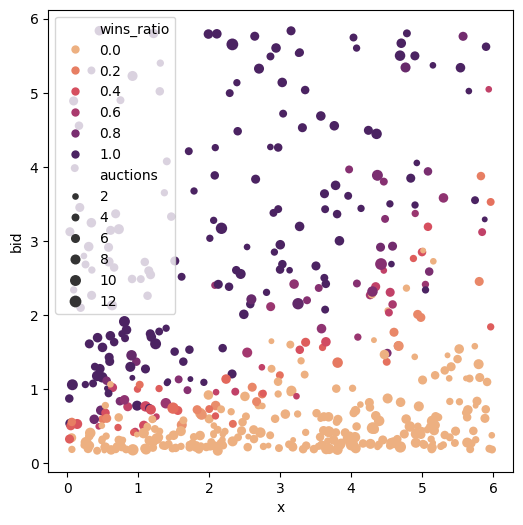

In [8]:
f, ax = plt.subplots(figsize=(6, 6))
# sns.despine(f, left=True, bottom=True)
sns.scatterplot(
    x="x", y="bid", hue="wins_ratio", size="auctions",
    palette="flare", linewidth=0, data=df_data, ax=ax
)

## Training and exploration

### Data split

In [9]:
df_data.loc[:, ["win"]] = df_data.loc[:, ["wins", "losses"]].apply(lambda s: [0]*s['losses'] + [1]*s['wins'], axis=1)
df_data_expanded = df_data.explode("win", ignore_index=True)\
    .astype({"win": int})\
    .sample(frac=1)
df_data_expanded.describe()

,x,bid,auctions,wins,losses,wins_ratio,win
count,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000
mean,2.811986,1.614155,6.070224,2.604943,3.465281,0.424872,0.424872
std,1.732706,1.574560,2.226255,3.076802,3.181961,0.451324,0.494421
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.178089,0.407546,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2.807454,0.932589,6.000000,1.000000,3.000000,0.200000,0.000000
75%,4.346854,2.426483,7.000000,5.000000,6.000000,1.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000,1.000000


In [10]:
X = df_data_expanded[["x", "bid"]].to_numpy()
y = df_data_expanded["win"].to_numpy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

### Training

In [12]:
# CV model
model = lgb.LGBMClassifier(random_state=random_state)
kfold = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[LightGBM] [Info] Number of positive: 793, number of negative: 1042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432153 -> initscore=-0.273074
[LightGBM] [Info] Start training from score -0.273074
[LightGBM] [Info] Number of positive: 793, number of negative: 1042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432153 -> initscore=-0.273074
[LightGBM] [In

In [13]:
early_stopping = lgb.early_stopping(stopping_rounds=10)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping]
)

[LightGBM] [Info] Number of positive: 882, number of negative: 1157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432565 -> initscore=-0.271394
[LightGBM] [Info] Start training from score -0.271394
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.216572


LGBMClassifier(random_state=7)

In [14]:
model.predict_proba(X_test[None,0,:])

array([[0.38291163, 0.61708837]])

In [19]:
params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'metric': 'binary_logloss',
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': None,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': 7,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}

In [20]:
cv = lgb.cv(
    params,
    lgb.Dataset(np.vstack((X_train, X_val)),np.hstack((y_train, y_val))),
    folds=kfold,
    callbacks=[early_stopping],
    return_cvbooster=True
)
clf = cv['cvbooster'].boosters[-1]

d:\Loan\Documents\Code\exercise_auction\devenv\lib\site-packages\lightgbm\engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 886, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 2
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 886, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the 

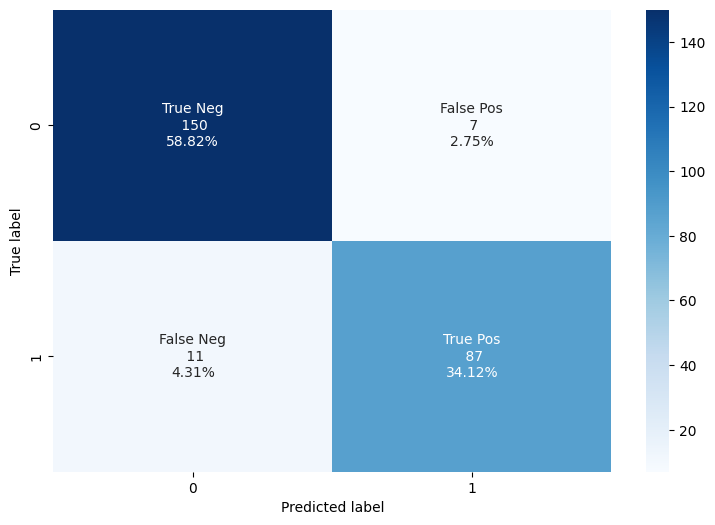

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.932     0.955     0.943       157
           1      0.926     0.888     0.906        98

    accuracy                          0.929       255
   macro avg      0.929     0.922     0.925       255
weighted avg      0.929     0.929     0.929       255

-------------------------------------------------------



In [21]:
y_pred = clf.predict(X_test)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred]))

`## Probability density function for ``x=3``

In [130]:
N = 10000
bid_min, bid_max = -1, 7
z = uniform.rvs(loc=bid_min, scale=bid_max, size=(10000, 1))
X_density3 = np.hstack((np.full((N, 1), 3), z))
y_density3 = clf.predict(X_density3)

In [131]:
density = gaussian_kde(X_density3[y_density3 > 0.5][:, 1])
u = np.linspace(bid_min, bid_max, 500)
v = density.evaluate(u)

In [132]:
density.integrate_box_1d(1, 2)

0.07725090914101301

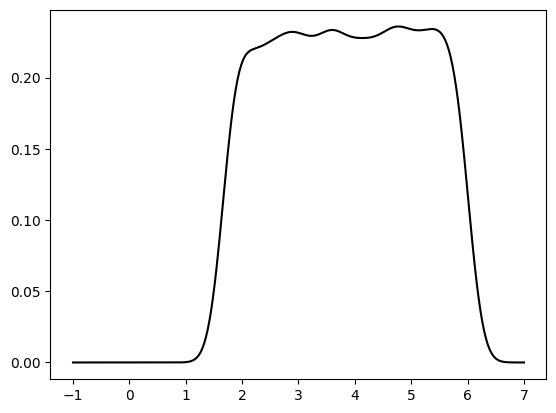

In [133]:
plt.plot(u, v, 'k')

## Cost computation

In [ ]:
from itertools import combinations

In [18]:
len(list(combinations(X[:, 1], 3)))

In [355]:
def compute_proba_cost(bid_array, y):
    for n_perm in range(n = len(y)):
        pool = tuple(iterable)
        n = len(pool)
        if r > n:
            return
        indices = list(range(r))
        yield tuple(pool[i] for i in indices)
        while True:
            for i in reversed(range(r)):
                if indices[i] != i + n - r:
                    break
            else:
                return
            indices[i] += 1
            for j in range(i+1, r):
                indices[j] = indices[j-1] + 1
            yield tuple(pool[i] for i in indices)

SyntaxError: expected ':' (3268242926.py, line 5)

In [348]:
df_data[(2.85 < df_data['x']) & (df_data['x'] < 3.15)].sort_values('bid')

,x,bid,auctions,wins,losses,wins_ratio,win
363,2.982830,0.205220,4,0,4,0.000000,"[0, 0, 0, 0]"
175,3.124571,0.255533,4,0,4,0.000000,"[0, 0, 0, 0]"
495,2.858668,0.378185,4,0,4,0.000000,"[0, 0, 0, 0]"
337,2.928406,0.601190,5,0,5,0.000000,"[0, 0, 0, 0, 0]"
165,3.072622,0.664044,7,0,7,0.000000,"[0, 0, 0, 0, 0, 0, 0]"
85,2.971225,0.935213,3,0,3,0.000000,"[0, 0, 0]"
57,3.145366,0.958012,4,0,4,0.000000,"[0, 0, 0, 0]"
389,2.969726,1.101010,5,0,5,0.000000,"[0, 0, 0, 0, 0]"
223,2.995172,1.188788,4,1,3,0.250000,"[0, 0, 0, 1]"
295,2.878089,1.275762,4,0,4,0.000000,"[0, 0, 0, 0]"
